In [15]:
import sys, json
import seaborn as sns
sns.set_style("whitegrid")
from tqdm import tqdm as tqdm
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm

In [16]:
BASE_PATH = "/ssd2/kishen/centroidHAC/"
# BASE_PATH = "/home/kishen/CentroidHAC/data1/"

datasets = {
    "iris",
    "digits",
    "wine",
    "breast_cancer",
    "faces",
    # "mnist",
    # "birds",
}

In [17]:
def read_dendrogram(input_file):
    with open(input_file, "r") as f:
        data = f.readlines()
        n = int(data[0])
        parent = [int(data[i]) for i in range(1, 2*n)]
        merge_cost = [float(data[i]) for i in range(2*n, 3*n-1)]
    return n, parent, merge_cost

In [18]:
eps2 = [0.01,0.05]
eps1 =[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
eps = eps2+eps1
# sklearn_linkage = ["ward", "complete", "average", "single"]
fastcluster_linkage = ["centroid", "single", "complete", "average", "ward"] #, "weighted", "median"]
algs_centroid = ["centroid_%.2f"%i for i in eps2] +["centroid_%.1f"%i for i in eps1]
algs_centroid_bucket = ["centroid_bucket_%.2f"%i for i in eps2] +["centroid_bucket_%.1f"%i for i in eps1]
algs_fc = [f"fastcluster_{linkage}" for linkage in fastcluster_linkage] # ["centroid_exact"]+
# algs += [f"sklearn_{linkage}" for linkage in sklearn_linkage]
names = {
    "centroid_exact": r"$Centroid_{exact}$ (Heap)",
    "fastcluster_centroid": r"$Centroid_{exact}$ (FC)",
    "fastcluster_single": "Single (FC)",
    "fastcluster_complete": "Complete (FC)",
    "fastcluster_average": "Average (FC)",
    "fastcluster_ward": "Ward (FC)",
    "centroid_0.01": r"$Centroid_{0.01}$ (Heap)",
    "centroid_0.05": r"$Centroid_{0.05}$ (Heap)",
	"centroid_0.1": r"$Centroid_{0.1}$ (Heap)",
    "centroid_0.2": r"$Centroid_{0.2}$ (Heap)",
    "centroid_0.3": r"$Centroid_{0.3}$ (Heap)",
    "centroid_0.4": r"$Centroid_{0.4}$ (Heap)",
    "centroid_0.5": r"$Centroid_{0.5}$ (Heap)",
    "centroid_0.6": r"$Centroid_{0.6}$ (Heap)",
    "centroid_0.7": r"$Centroid_{0.7}$ (Heap)",
    "centroid_0.8": r"$Centroid_{0.8}$ (Heap)",
    "centroid_0.9": r"$Centroid_{0.9}$ (Heap)",
    "centroid_bucket_0.1": r"$Centroid_{0.1}$ (Bucket)",
    "centroid_bucket_0.2": r"$Centroid_{0.2}$ (Bucket)",
    "centroid_bucket_0.3": r"$Centroid_{0.3}$ (Bucket)",
    "centroid_bucket_0.4": r"$Centroid_{0.4}$ (Bucket)",
    "centroid_bucket_0.5": r"$Centroid_{0.5}$ (Bucket)",
    "centroid_bucket_0.6": r"$Centroid_{0.6}$ (Bucket)",
    "centroid_bucket_0.7": r"$Centroid_{0.7}$ (Bucket)",
    "centroid_bucket_0.8": r"$Centroid_{0.8}$ (Bucket)",
    "centroid_bucket_0.9": r"$Centroid_{0.9}$ (Bucket)",
}
stat_map = {
    "ARI": "ari_score",
    "NMI": "ami_score",
    "Purity": "dendrogram_purity",
    "Dasgupta": "dasgupta_cost",
}

In [19]:
plt.rcParams["figure.figsize"] = (10,6)
def plot_stat(dataset,stat_name):
    plt.clf()
    stat = stat_map[stat_name]
    with open(BASE_PATH + f"basic/{dataset}/stats/{dataset}_stats.json", "r") as f:
        data = json.load(f)
    color = iter(cm.rainbow(np.linspace(0, 1, len(algs_fc)+2)))
    # Plotting Centroid
    centroid_stat_vals = [data[stat][alg] for alg in algs_centroid]
    c = next(color)
    plt.plot(eps, centroid_stat_vals, 'x-', label=r"$Centroid_\epsilon$ (Heap)", c=c)
    # Plotting Centroid Bucket
    centroid_bucket_stat_vals = [data[stat][alg] for alg in algs_centroid_bucket]
    c = next(color)
    plt.plot(eps, centroid_bucket_stat_vals, "o-", label=r"$Centroid_\epsilon$ (Bucket)", c=c)
    # Plotting Rest Algs
    for alg in algs_fc:
        c = next(color)
        if alg == "fastcluster_centroid":
            plt.hlines(y=data[stat][alg],xmin=0,xmax=1,colors=c,linestyles='dotted',label=names[alg])
        else:
            plt.hlines(y=data[stat][alg],xmin=0,xmax=1,colors=c,linestyles='dashed',label=names[alg])
    
    # sns.set_style("darkgrid")
    plt.xlabel(r'$\epsilon$')
    # plt.xlim(0,1)
    plt.ylabel(stat_name)
    # plt.ylim(0,1)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.savefig(BASE_PATH+f"basic/plots/{dataset}_{stat}.pdf", format="pdf", bbox_inches="tight")
    # plt.show()

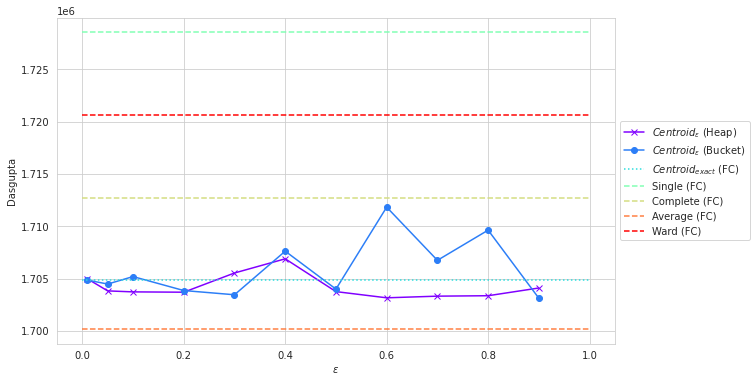

In [20]:
for dataset in datasets:
    plot_stat(dataset,"ARI")
    plot_stat(dataset,"NMI")
    plot_stat(dataset,"Purity")
    plot_stat(dataset,"Dasgupta")

In [45]:
def inversions_eps(dendrogram_file, eps = 0):
    n, dend, merge_costs = read_dendrogram(dendrogram_file)
    inv = 0
    one_plus_eps = 1 + eps
    for i in range(n):
        d = merge_costs[dend[i]-n]
        d_scaled = d/one_plus_eps
        i = dend[i]
        while dend[i] != i:
            if merge_costs[dend[i]-n] <= d_scaled:
                inv += 1
            i = dend[i]
    return inv

def compute_inversions_general(dataset, method, eps, is_basic=True):
    if is_basic:
        dendrogram_file = BASE_PATH + f"basic/{dataset}/dend/{dataset}_dend_{method}.txt"
    else:
        dendrogram_file = BASE_PATH + f"{dataset}/dend/{dataset}_dend_{method}.txt"
    inv = inversions_eps(dendrogram_file, eps)
    return inv

In [62]:
plt.rcParams["figure.figsize"] = (10,6)
def plot_inv(dataset,is_basic=True):
    plt.clf()
    epss = np.arange(0,1,0.02)
    algs = ["centroid_0.05"]+["centroid_%.1f"%i for i in [0.1,0.2,0.4,0.8]]+["fastcluster_centroid"]
    invs_map = {alg:[compute_inversions_general(dataset, alg, epsil, is_basic) for epsil in epss] for alg in tqdm(algs)}    
    color = iter(cm.rainbow(np.linspace(0, 1, len(algs))))
    # Plotting Centroid
    for alg in algs:
        c = next(color)
        plt.plot(epss, invs_map[alg], 'o-', label=names[alg], c=c)
    # sns.set_style("darkgrid")
    plt.xlabel(r'$\delta$')
    # plt.xlim(0,1)
    plt.ylabel(r"# $\delta$-Inversions")
    # plt.ylim(0,1)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.savefig(BASE_PATH+f"basic/plots/{dataset}_invs.pdf", format="pdf", bbox_inches="tight")
    # plt.show()

100%|██████████| 6/6 [00:00<00:00,  7.21it/s]


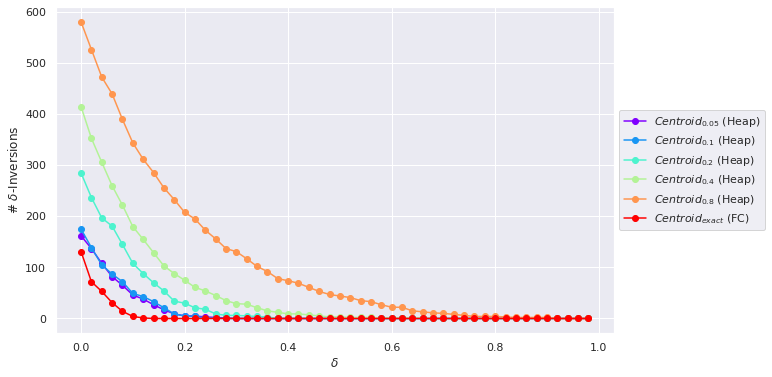

In [63]:
for dataset in datasets:
    plot_inv(dataset,1)

# Running Time Plots

log(size)-log(time)

In [24]:
# Average of 5 rounds
sizes = [32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384, 32768, 65536, 131072, 262144, 524288, 1000000]
centroid_time = [0.0067, 0.0145, 0.0279, 0.0475, 0.0726, 0.1376, 0.2748, 0.5865, 1.2813, 2.7979, 5.8185, 13.0342, 29.4244, 69.1795, 157.3989, 355.3993]
centroid_bkt_time = [0.0083, 0.0128, 0.0339, 0.057, 0.1056, 0.2037, 0.3679, 0.7173, 1.47, 3.0231, 7.0469, 13.9862, 33.9967, 88.0933, 250.3952, 554.8045]
fc_time = [0.0003636837006, 0.0007602214813, 0.002085351944, 0.005698442459, 0.01422071457, 0.03847680092, 0.1283622265, 0.5448870659, 2.289772415, 9.653276062, 47.29846959, 266.6447304, 1306.314334, 5718.182213, 27654.86675]

In [27]:
def plot_time_log(sizes, centroid_time, centroid_bkt_time, fc_time):    
	plt.clf()
	# Plotting Centroid
	plt.plot(sizes, centroid_time, 'o-', label=r"Centroid$_{0.1}$ (H)")
	plt.plot(sizes, centroid_bkt_time, 'x-', label=r"Centroid$_{0.1}$ (B)")
	plt.plot(sizes[:-1], fc_time, '+-', label=r"FC Centroid")
	# sns.set_style("darkgrid")
	plt.xlabel("Number of Points (logscale)")
	plt.xscale("log")
	plt.ylabel("Running time in sec (logscale)")
	plt.yscale("log")
	plt.legend(loc='upper left')
	plt.savefig(BASE_PATH+f"sift/plots/running_time_vs_num_points_sift.pdf", format="pdf", bbox_inches="tight")
	plt.show()

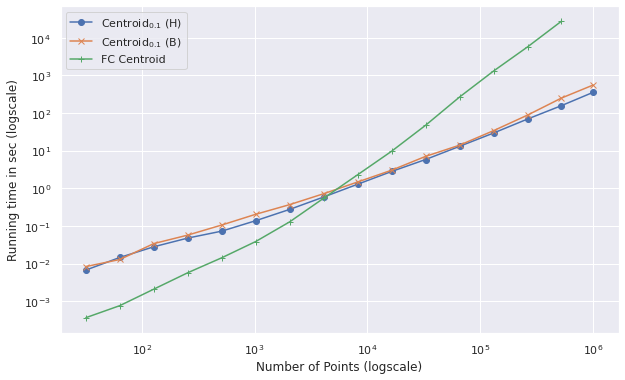

In [28]:
plot_time_log(sizes, centroid_time, centroid_bkt_time, fc_time)

running time vs eps

In [29]:
# Average of 3 rounds
epss = [0.01, 0.02, 0.04, 0.08, 0.16, 0.32, 0.64, 1.28]
centroid_time_eps = [403.1182, 418.8278, 387.4787, 394.0165, 340.4001, 276.9795, 242.2629, 205.2624]
centroid_bkt_time_eps = [3624.9337, 1834.1614, 1023.0279, 631.3644, 449.3939, 342.5362, 281.6488, 238.4251]

In [34]:
def plot_time_log_eps(epss, centroid_time, centroid_bkt_time):    
	plt.clf()
	# Plotting Centroid
	plt.plot(epss, centroid_time, 'o-', label=r"Centroid$_{\epsilon}$ (H)")
	plt.plot(epss, centroid_bkt_time, 'x-', label=r"Centroid$_{\epsilon}$ (B)")
	# sns.set_style("darkgrid")
	plt.xlabel(r"$\epsilon$")
	plt.ylabel("Running time in sec")
	plt.legend(loc='upper right')
	plt.savefig(BASE_PATH+f"sift/plots/running_time_vs_eps_sift.pdf", format="pdf", bbox_inches="tight")
	plt.show()

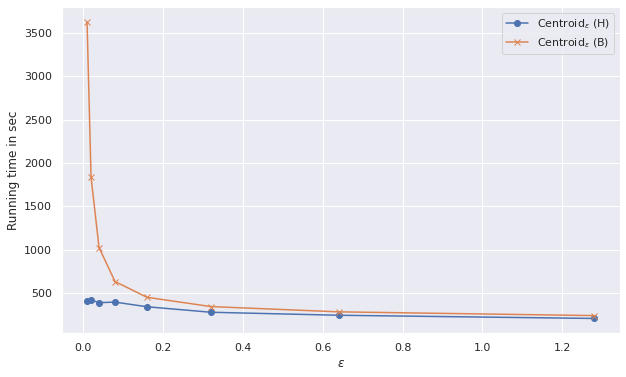

In [35]:
plot_time_log_eps(epss, centroid_time_eps, centroid_bkt_time_eps)

ANNS Queries vs eps

In [ ]:
epss = [0.01, 0.02, 0.04, 0.08, 0.16, 0.32, 0.64, 1.28]
centroid_qs_eps = []
centroid_bkt_qs_eps = [3624.9337, 1834.1614, 1023.0279, 631.3644, 449.3939, 342.5362, 281.6488, 238.4251]